<a href="https://colab.research.google.com/github/imtisalrangrez/MLlab_180/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: .. _breast_cancer_dataset:
Shape X: (569, 30) y: (569,)
Train+Val shape: (455, 30) Test shape: (114, 30)

Objective (binary logistic regression with L2 regularization):

Given dataset {(x_n, y_n)}_{n=1}^N with y_n in {0,1}, and model p(y=1|x) = sigma(w^T phi(x) + b),
the regularized negative log-likelihood (to minimize) is:

L(w,b) = - sum_{n=1}^N [ y_n log(p_n) + (1-y_n) log(1-p_n) ] + (lambda/2) * ||w||_2^2

where p_n = sigma(w^T phi(x_n) + b) and sigma(t)=1/(1+exp(-t)).
Note: the bias b is typically not regularized.


Results (first rows):
    lambda  train_logloss  test_logloss  train_acc  test_acc     l2_norm
0     0.0       0.000286      2.585881   1.000000  0.921053  929.480672
1     0.1       0.036498      0.079494   0.991209  0.964912    7.973224
2     1.0       0.051381      0.077825   0.989011  0.982456    3.592127
3    10.0       0.083942      0.106934   0.984615  0.973684    1.824553
4   100.0       0.171906      0.185537   0.958242  0.947368    0.833240
5  1000.0

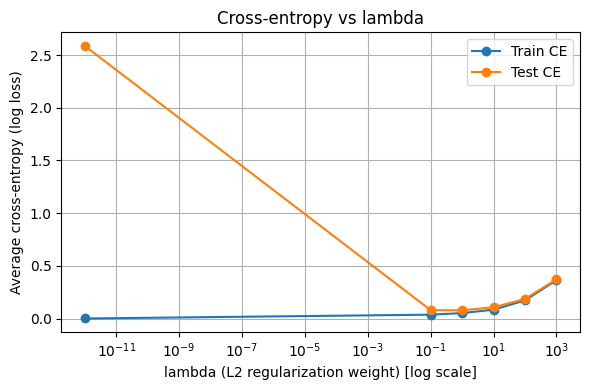

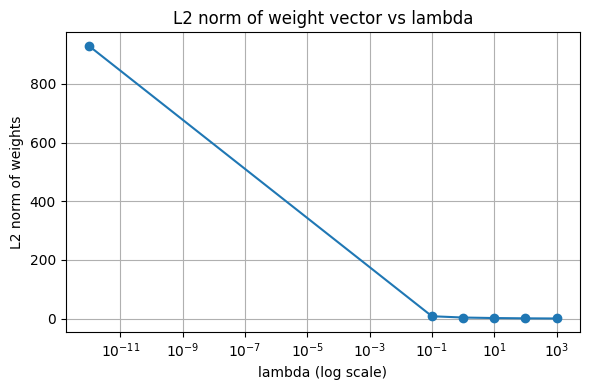

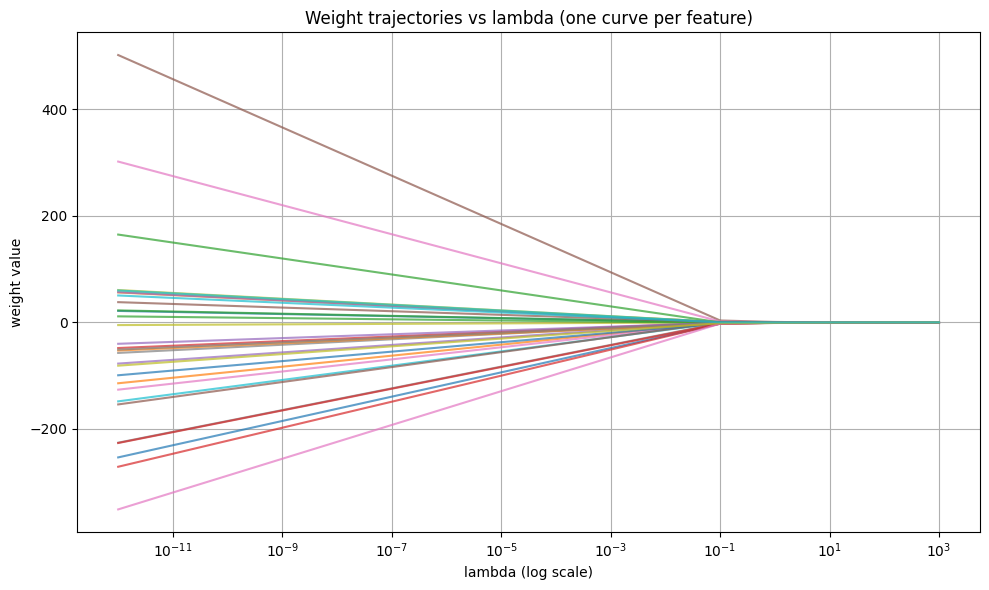

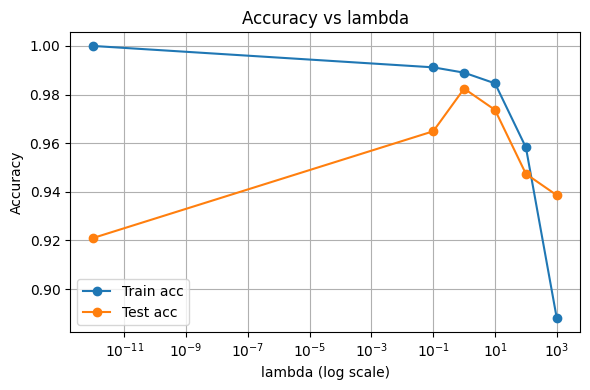

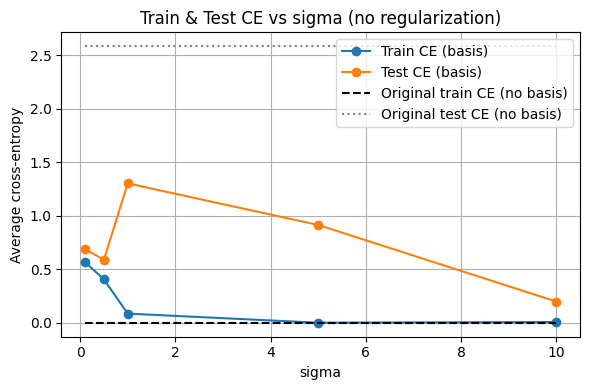

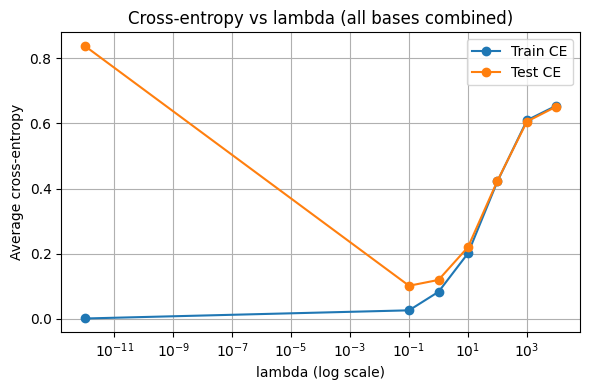

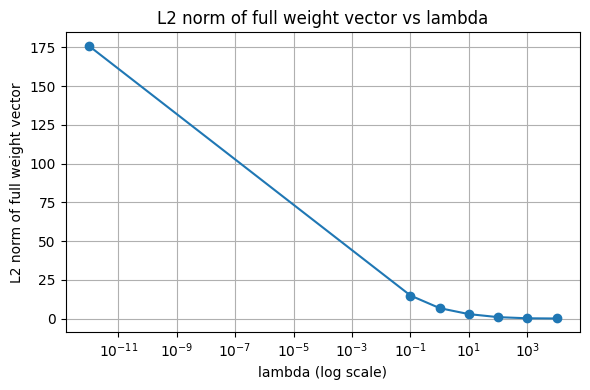

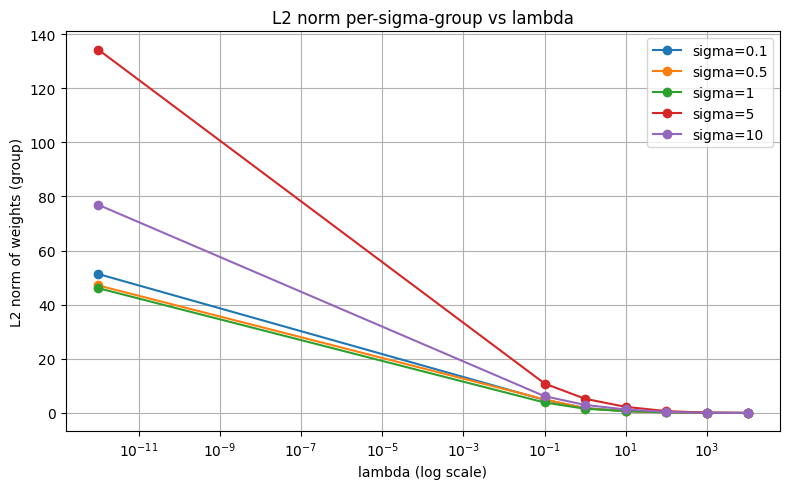

In [ ]:
# ML_Assignment1_Logistic_BasisFunctions.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from itertools import product
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

data = load_breast_cancer()
X_full = data['data']
y_full = data['target']
feature_names = data['feature_names']

print("Dataset:", data['DESCR'].splitlines()[0])
print("Shape X:", X_full.shape, "y:", y_full.shape)

# Standardize features (important before applying Gaussian basis expansions).
scaler = StandardScaler()
X_std = scaler.fit_transform(X_full)

X = X_std.copy()
y = y_full.copy()


X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train+Val shape:", X_trainval.shape, "Test shape:", X_test.shape)


def l2_norm(coef):
    return np.sqrt(np.sum(coef**2))


def avg_cross_entropy(model, X, y):
    probs = model.predict_proba(X)
    return log_loss(y, probs, labels=model.classes_)

def fit_logistic_L2(X, y, lam, max_iter=5000):
    if lam == 0:
        # approximate "no regularization" with very large C
        C = 1e12
    else:
        C = 1.0 / lam
    # use solver 'lbfgs' (works for small datasets). penalty='l2' is default.
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=max_iter)
    model.fit(X, y)
    return model


objective_text = """
Objective (binary logistic regression with L2 regularization):

Given dataset {(x_n, y_n)}_{n=1}^N with y_n in {0,1}, and model p(y=1|x) = sigma(w^T phi(x) + b),
the regularized negative log-likelihood (to minimize) is:

L(w,b) = - sum_{n=1}^N [ y_n log(p_n) + (1-y_n) log(1-p_n) ] + (lambda/2) * ||w||_2^2

where p_n = sigma(w^T phi(x_n) + b) and sigma(t)=1/(1+exp(-t)).
Note: the bias b is typically not regularized.
"""
print(objective_text)



lambdas = [0, 0.1, 1, 10, 100, 1000]
train_losses = []
test_losses = []
train_accs = []
test_accs = []
l2_norms = []
weights_per_lambda = []

# We'll fit on train+val (80%) and evaluate loss on both train+val and test.
for lam in lambdas:
    model = fit_logistic_L2(X_trainval, y_trainval, lam)
    tr_loss = avg_cross_entropy(model, X_trainval, y_trainval)
    te_loss = avg_cross_entropy(model, X_test, y_test)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    l2_norms.append(l2_norm(model.coef_))
    weights_per_lambda.append(model.coef_.ravel().copy())
    train_accs.append(accuracy_score(y_trainval, model.predict(X_trainval)))
    test_accs.append(accuracy_score(y_test, model.predict(X_test)))

# Plotting results
plt.figure(figsize=(6,4))
plt.semilogx([max(l,1e-12) for l in lambdas], train_losses, marker='o', label='Train CE')
plt.semilogx([max(l,1e-12) for l in lambdas], test_losses, marker='o', label='Test CE')
plt.xlabel('lambda (L2 regularization weight) [log scale]')
plt.ylabel('Average cross-entropy (log loss)')
plt.title('Cross-entropy vs lambda')
plt.legend(); plt.grid(True); plt.tight_layout()

plt.figure(figsize=(6,4))
plt.semilogx([max(l,1e-12) for l in lambdas], l2_norms, marker='o')
plt.xlabel('lambda (log scale)'); plt.ylabel('L2 norm of weights')
plt.title('L2 norm of weight vector vs lambda'); plt.grid(True); plt.tight_layout()

# weights per feature vs lambda
weights_arr = np.vstack(weights_per_lambda)  # shape (len(lambdas), n_features)
plt.figure(figsize=(10,6))
for i in range(weights_arr.shape[1]):
    plt.semilogx([max(l,1e-12) for l in lambdas], weights_arr[:, i], alpha=0.7)
plt.xlabel('lambda (log scale)')
plt.ylabel('weight value')
plt.title('Weight trajectories vs lambda (one curve per feature)')
plt.grid(True); plt.tight_layout()

plt.figure(figsize=(6,4))
plt.semilogx([max(l,1e-12) for l in lambdas], train_accs, marker='o', label='Train acc')
plt.semilogx([max(l,1e-12) for l in lambdas], test_accs, marker='o', label='Test acc')
plt.xlabel('lambda (log scale)'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Accuracy vs lambda'); plt.grid(True); plt.tight_layout()

# Save numeric results into a DataFrame to show
res_df = pd.DataFrame({
    'lambda': lambdas,
    'train_logloss': train_losses,
    'test_logloss': test_losses,
    'train_acc': train_accs,
    'test_acc': test_accs,
    'l2_norm': l2_norms
})
print("\nResults (first rows):\n", res_df)



def make_univariate_gaussian_bases(X, mus, sigma):
    # X: (n_samples, ) single feature values
    # mus: array of means (k,)
    # returns (n_samples, k) matrix where entry = exp(- (x - mu)^2 / (2*sigma^2))
    X_col = X[:, np.newaxis]
    mus = mus[np.newaxis, :]
    phi = np.exp(- (X_col - mus)**2 / (2.0 * sigma**2))
    return phi

def transform_with_bases(X, sigma, means_span=(-10,10), n_bases=5, include_bias=True):
    n_samples, n_features = X.shape
    # For each feature, create n_bases basis functions with means evenly spaced in means_span.
    phi_list = []
    bases_info = []  # keep track which columns belong to which feature and mean
    for feat_idx in range(n_features):
        feature_values = X[:, feat_idx]
        mus = np.linspace(means_span[0], means_span[1], n_bases)
        phi_feat = make_univariate_gaussian_bases(feature_values, mus, sigma)
        phi_list.append(phi_feat)
        bases_info.extend([ (feat_idx, mu, sigma) for mu in mus ])
    PHI = np.hstack(phi_list)
    if include_bias:
        PHI = np.hstack([np.ones((n_samples,1)), PHI])

        bases_info = [("bias", 0, 0)] + bases_info
    return PHI, bases_info

# quick sanity check on shapes
PHI_train_1sigma, info_1 = transform_with_bases(X_trainval, sigma=1.0)
print("Transformed PHI shape (sigma=1):", PHI_train_1sigma.shape, "example bases count:", len(info_1))


sigmas = [0.1, 0.5, 1, 5, 10]
train_logloss_sigma = []
test_logloss_sigma = []

for sigma in sigmas:
    PHI_train, info = transform_with_bases(X_trainval, sigma=sigma, include_bias=True)
    PHI_test, _ = transform_with_bases(X_test, sigma=sigma, include_bias=True)

    model = LogisticRegression(penalty='l2', C=1e12, solver='lbfgs', max_iter=5000)
    model.fit(PHI_train, y_trainval)
    train_logloss_sigma.append(log_loss(y_trainval, model.predict_proba(PHI_train), labels=model.classes_))
    test_logloss_sigma.append(log_loss(y_test, model.predict_proba(PHI_test), labels=model.classes_))

# Constant lines from part (d): using original features, no basis functions

lambda0_idx = lambdas.index(0)
orig_train_ce = train_losses[lambda0_idx]
orig_test_ce = test_losses[lambda0_idx]

plt.figure(figsize=(6,4))
plt.plot(sigmas, train_logloss_sigma, marker='o', label='Train CE (basis)')
plt.plot(sigmas, test_logloss_sigma, marker='o', label='Test CE (basis)')
plt.hlines(orig_train_ce, xmin=min(sigmas), xmax=max(sigmas), colors='k', linestyles='--',
           label='Original train CE (no basis)')
plt.hlines(orig_test_ce, xmin=min(sigmas), xmax=max(sigmas), colors='gray', linestyles=':',
           label='Original test CE (no basis)')
plt.xscale('linear')
plt.xlabel('sigma')
plt.ylabel('Average cross-entropy')
plt.title('Train & Test CE vs sigma (no regularization)')
plt.legend(); plt.grid(True); plt.tight_layout()


all_sigmas = sigmas
def build_all_sigma_bases(X, sigmas, include_bias=True):

    phi_parts = []
    info = []
    for sigma in sigmas:
        PHI_sigma, info_sigma = transform_with_bases(X, sigma=sigma, include_bias=False)
        phi_parts.append(PHI_sigma)

        info.append(('sigma', sigma, PHI_sigma.shape[1]))
    PHI_all = np.hstack(phi_parts)
    if include_bias:
        PHI_all = np.hstack([np.ones((PHI_all.shape[0],1)), PHI_all])

    col_ranges = {}
    start = 1 if include_bias else 0
    for (_, sigma, width) in info:
        col_ranges[sigma] = (start, start + width)
        start += width
    return PHI_all, col_ranges

PHI_train_all, col_ranges = build_all_sigma_bases(X_trainval, all_sigmas, include_bias=True)
PHI_test_all, _ = build_all_sigma_bases(X_test, all_sigmas, include_bias=True)
print("PHI_all shape:", PHI_train_all.shape)
print("Column ranges per sigma (start inclusive, end exclusive):", col_ranges)

lambdas_g = [0, 0.1, 1, 10, 100, 1000, 10000]
train_losses_g = []
test_losses_g = []
l2_norms_g = []
sigma_group_norms = {s: [] for s in all_sigmas}

for lam in lambdas_g:
    model = fit_logistic_L2(PHI_train_all, y_trainval, lam)
    tr_loss = log_loss(y_trainval, model.predict_proba(PHI_train_all), labels=model.classes_)
    te_loss = log_loss(y_test, model.predict_proba(PHI_test_all), labels=model.classes_)
    train_losses_g.append(tr_loss)
    test_losses_g.append(te_loss)
    l2_norms_g.append(l2_norm(model.coef_))
    full_coef = model.coef_.ravel()

    for sigma in all_sigmas:
        start, end = col_ranges[sigma]
        w_sigma = full_coef[start:end]
        sigma_group_norms[sigma].append(np.sqrt(np.sum(w_sigma**2)))

# Plots
plt.figure(figsize=(6,4))
plt.semilogx([max(l,1e-12) for l in lambdas_g], train_losses_g, marker='o', label='Train CE')
plt.semilogx([max(l,1e-12) for l in lambdas_g], test_losses_g, marker='o', label='Test CE')
plt.xlabel('lambda (log scale)'); plt.ylabel('Average cross-entropy'); plt.legend()
plt.title('Cross-entropy vs lambda (all bases combined)'); plt.grid(True); plt.tight_layout()

plt.figure(figsize=(6,4))
plt.semilogx([max(l,1e-12) for l in lambdas_g], l2_norms_g, marker='o')
plt.xlabel('lambda (log scale)'); plt.ylabel('L2 norm of full weight vector')
plt.title('L2 norm of full weight vector vs lambda'); plt.grid(True); plt.tight_layout()

plt.figure(figsize=(8,5))
for sigma in all_sigmas:
    plt.semilogx([max(l,1e-12) for l in lambdas_g], sigma_group_norms[sigma], marker='o', label=f'sigma={sigma}')
plt.xlabel('lambda (log scale)'); plt.ylabel('L2 norm of weights (group)')
plt.title('L2 norm per-sigma-group vs lambda'); plt.legend(); plt.grid(True); plt.tight_layout()

# Print summary table
res_g = pd.DataFrame({
    'lambda': lambdas_g,
    'train_logloss': train_losses_g,
    'test_logloss': test_losses_g,
    'l2_norm': l2_norms_g
})
print("\nAll-bases results:\n", res_g)
